<a href="https://colab.research.google.com/github/Leandro-Braga/Estudo_de_Caso/blob/main/Atividade_Day_ARIMA_ordem_p_d_q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tema: Modelagem ARIMA 


O estudo da modelagem autorregressiva integráveis de médias móveis ARIMA, de larga utilização na modelagem de séries estacionárias e não estacionárias integradas, é essencial para o profissional na análise de séries temporais financeiras, econômicas, logísticas, de negócios, gestão, entre outras, pois apresentam características distintas como valores defasados e que ocorrem contemporaneamente e em vários momentos no passado.

A primeira coisa é verificar a estacionariedade nos dados. A estacionaridade será verificada pelo Teste Dicky Fuller Aumentado. A hipótese nula para este teste é que a Série Temporal é não Estacionária. Assim, se o valor de p for menor que 1, rejeitaremos a hipótese nula e acreditaremos que a série é Estacionária.

In [1]:
# biblioteca de análise básica
import pandas as pd
import numpy as np
import seaborn as sns

# biblioteca de modelagem e testes
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# bibliotecas de visualização
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

# ignorando avisos
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Carreguaremos o arquivo Excel, com a séries.

In [9]:
n = 100
df = pd.DataFrame(dict(Day=pd.date_range("2021-1-1", 
                                           periods=n),
                       Value=np.random.normal(5, 1, n)))

In [10]:
df.head(100)

,Day,Value
0,2021-01-01,3.745412
1,2021-01-02,4.180482
2,2021-01-03,5.897133
3,2021-01-04,5.146392
4,2021-01-05,4.203034
...,...,...
95,2021-04-06,3.933524
96,2021-04-07,4.782934
97,2021-04-08,4.411154
98,2021-04-09,7.035886


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Day     100 non-null    datetime64[ns]
 1   Value   100 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 KB


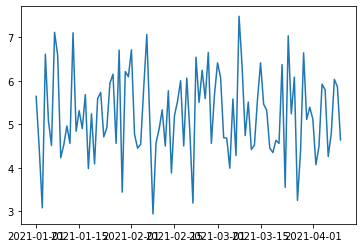

In [ ]:
# plotar gráfico da Produção Industrial mensal PIM-PF
plt.plot(df.Day, df.Value);

#### Identificação

In [12]:
result = adfuller(df.Value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.826562
p-value: 0.002647


O resultado acima é constante desde que |f| < 1, caso em que o termo f aproxima-se de zero. Desse modo, o modelo AR(1) não é estacionário, seria estácionario se e somente se |f| < 1, confirmando a condição de não estacionariedade desse modelo.

Antes de fazer a decomposição da série, temos que transformar a data em índice:

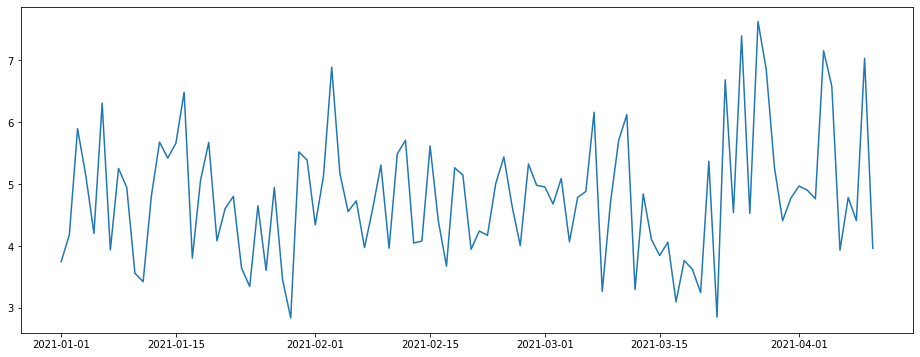

In [13]:
#Transformar da data em índice
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
df.Day = pd.to_datetime(df.Day)
df.set_index('Day', inplace=True)
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.plot(df)

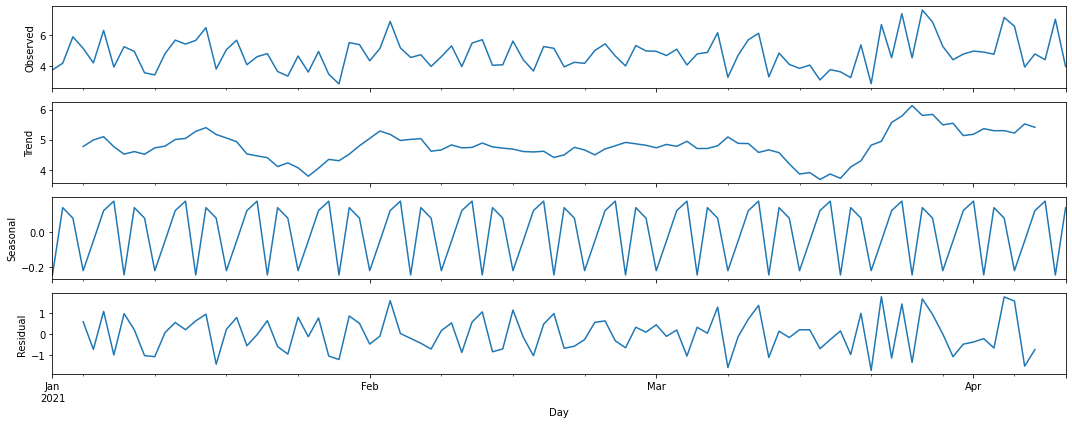

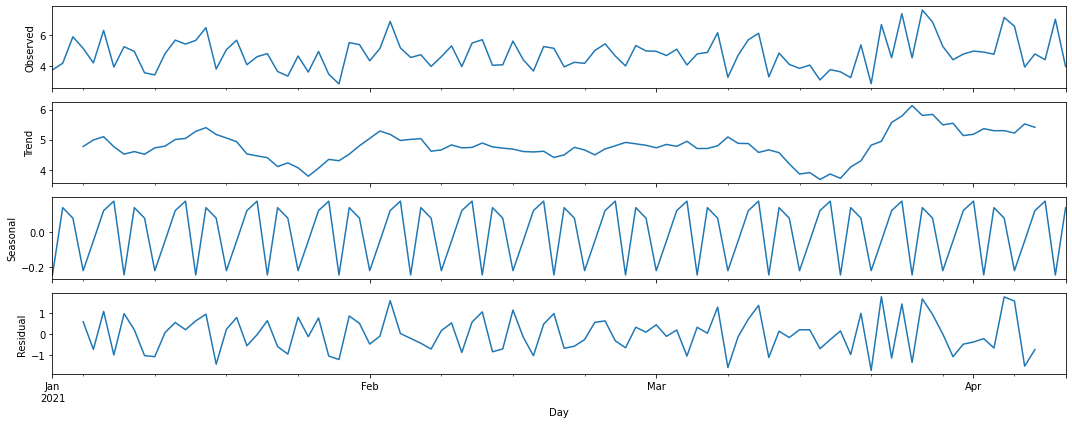

In [14]:
# salvar a decomposição no modelo aditivo
result = seasonal_decompose(df, model='additive')
result.plot()

Vamos aplicar a decomposição multiplicativa à série:

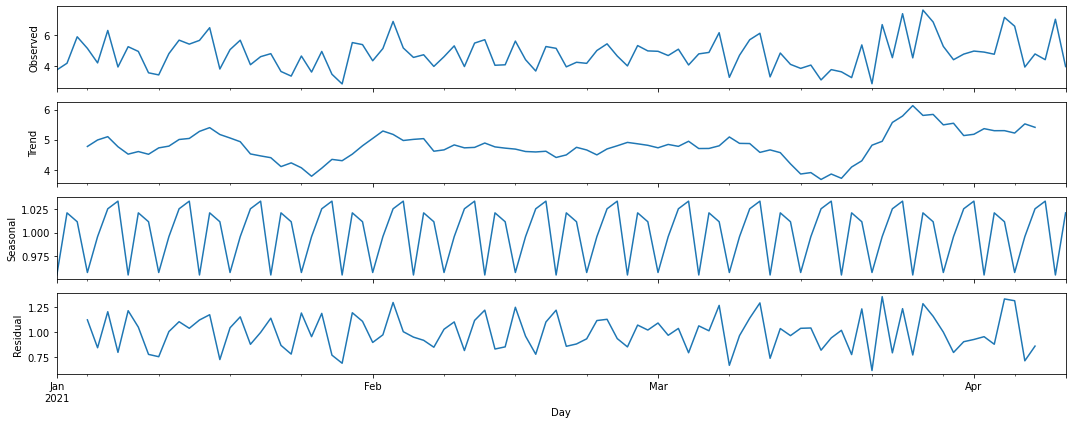

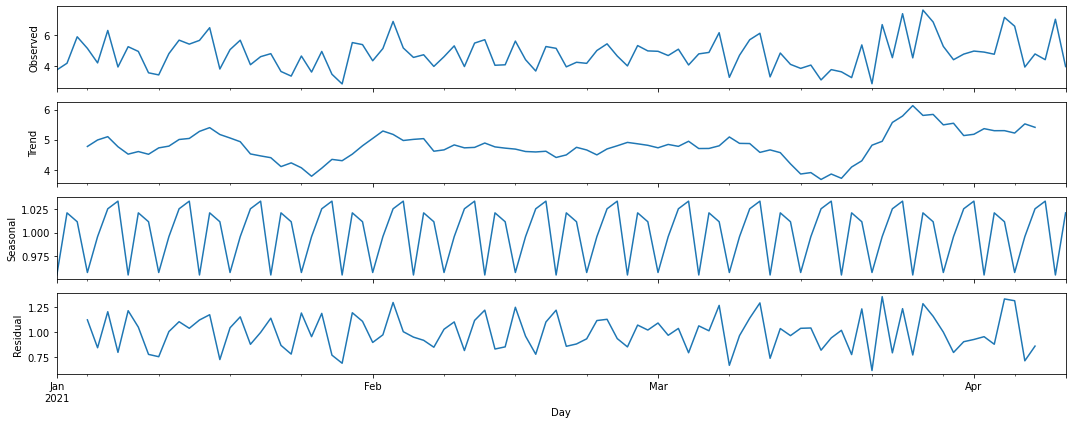

In [15]:
# decompõe a série de acordo com o modelo multiplicativo 
result = seasonal_decompose(df, model='multiplicative')
result.plot()

Observa-se um padrão muito similar entre os modelos de decomposição aditivo e multiplicativo, pois existe pouca ou nenhuma tendência na série. A diferença entre os modelos é maior quando a sazonalidade depende da tendência.

### Modelos de suavização para séries logísticas

Consiste em utilizar como previsão a média simples das observações mais recentes. Consideraremos a média de k valores consecutivos, podemos tomar a média do último ano, ou seja, os últimos 10 valores. O pacote Pandas tem funções específicas definidas para determinar médias móveis como:

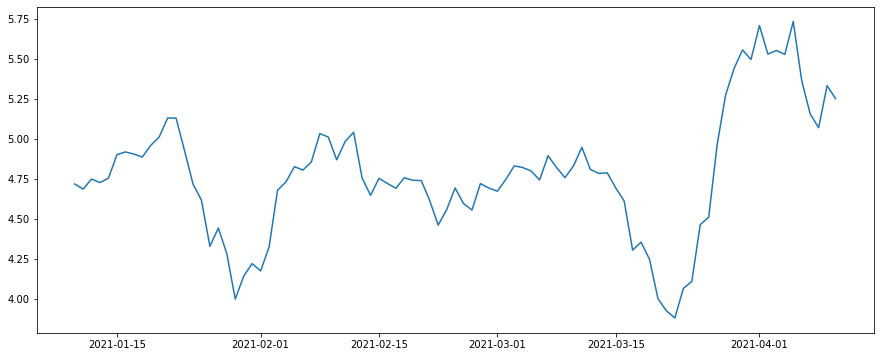

In [16]:
# Modelo de Médias Móveis com k=10
dados = df
mm = pd.DataFrame.rolling(dados,window=10,center=False).mean()
plt.plot(mm)

Outro exemplo:

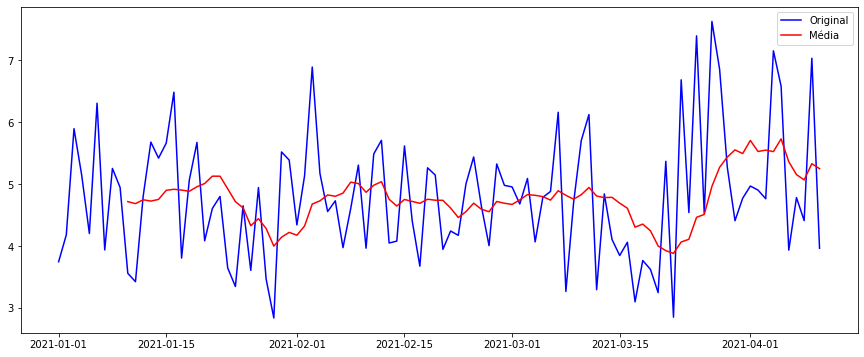

In [17]:
# Modelo de Médias Móveis comparado a série com k=10
mm = pd.DataFrame.rolling(dados,window=10,center=False).mean()
orig = plt.plot(dados, color='blue',label='Original')
mean = plt.plot(mm, color='red',label='Média')
plt.legend(loc='best')
plt.show()

Agora, vamos rodar o modelo de médias móveis para k=4, e o resultado obtido está ilustrado no gráfico a seguir:

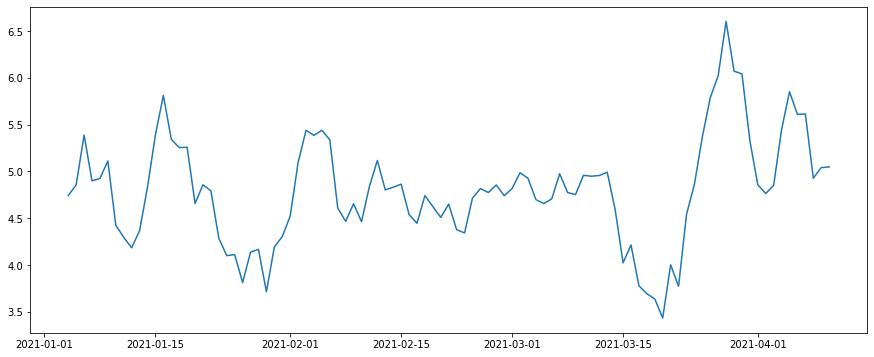

In [18]:
# Modelo de Médias Móveis com k=4
mm = pd.DataFrame.rolling(dados,window=4,center=False).mean()
plt.plot(mm)

Vamos executar o código com k=4.

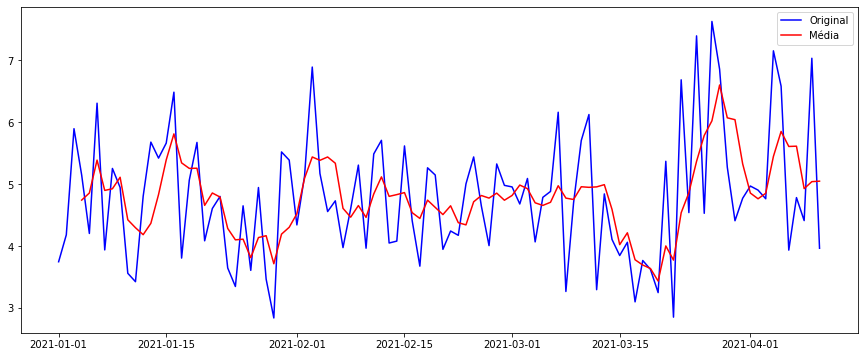

In [19]:
# Modelo de Médias Móveis comparado a série com k=4
mm = pd.DataFrame.rolling(dados,window=4,center=False).mean()
orig = plt.plot(dados, color='blue',label='Original')
mean = plt.plot(mm, color='red',label='Média')
plt.legend(loc='best')
plt.show()

Os dois modelos suavizam a série logística. No entanto, comparando-se o modelo médias móveis com k=10 e com k=4 observa-se que o modelo com k=10 retira os picos sazonais, o que não ocorre com k=4. Se quisermos realizar previsões para a série sem sazonalidade, devemos escolher o modelo de médias móveis com k=10.

Para contornar esse problema, surge o método do amortecimento exponencial. Para realizar previsões K passos à frente utilizando o modelo de médias móveis, utilizamos o seguinte código para previsão 1 passo à frente e 10 passos à frente:

In [20]:
def moving_average(series, n):
    '''Calcula a média das últimas n observações'''
    return np.average(series[-n:])

Calculando a previsão para 10 passos à frente:

In [21]:
# Previsão 10 passos à frente
moving_average(dados, 10)

5.250573286914991

Agora, calculando a previsão para 1 passo à frente:

In [22]:
# Previsão 1 passos à frente
moving_average(dados, 1)

3.9636509055157987

### Método amortecimento exponencial para séries logísticas

Vamos executar o código para Amortecimento Exponencial (sem constante de amortecimento) a seguir:

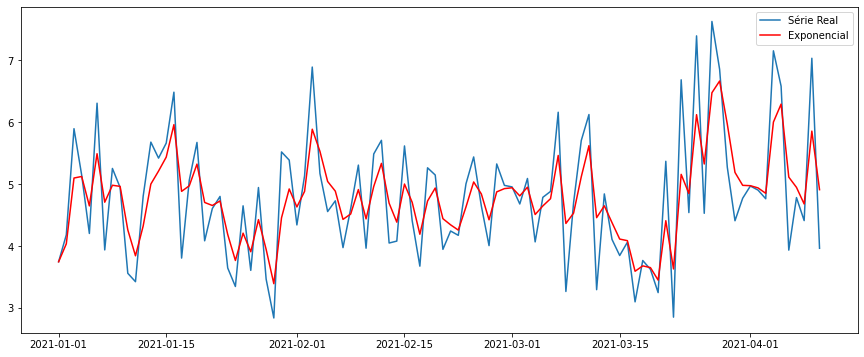

In [23]:
# Amortecimento Exponencial alfa = 0,5
rolling = dados.ewm(alpha=0.5)
rolling_mean = rolling.mean()
plt.plot(dados, label='Série Real')
plt.plot(rolling_mean, color='red', label='Exponencial')
plt.legend(loc='best')
plt.show()

Agora, vamos executar o código Python para Amortecimento Exponencial (com constante de amortecimento = 0,3).

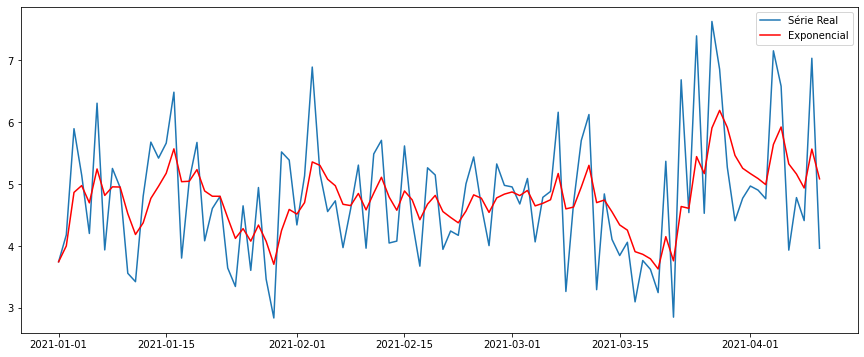

In [24]:
# Amortecimento Exponencial alfa = 0,3
rolling = dados.ewm(alpha=0.3)
rolling_mean = rolling.mean()
plt.plot(dados, label='Série Real')
plt.plot(rolling_mean, color='red', label='Exponencial')
plt.legend(loc='best')
plt.show()

Gráfico comparando mais de um valor da constante de amortecimento:

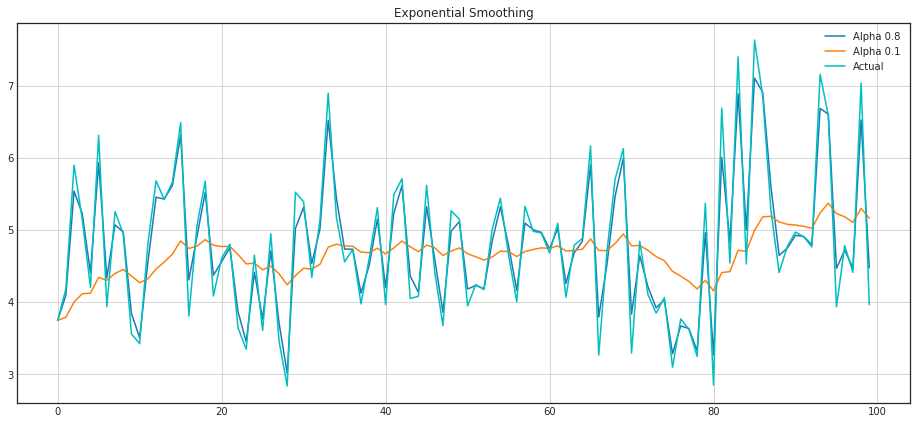

In [25]:
#Função para comparação com duas constantes de amortecimento:
def exponential_smoothing(series, alpha):
    '''
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    '''
    result = [series[0]] # o primeiro valor é o mesmo que a série
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    '''
        Plota suavização exponencial com diferentes alfas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    '''
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(16, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label='Alpha {}'.format(alpha))
        plt.plot(series.values, 'c', label = 'Actual')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title('Exponential Smoothing')
        plt.grid(True);
plotExponentialSmoothing(dados.Value, [0.8, 0.1])

Gráfico: Comparação com duas constantes de amortecimento.

### Método de Holt Winters para séries logísticas

O método de Holt-Winters compreende a equação de previsão e três equações de suavização.

Primeiramente, rodaremos o modelo de Holt-Winters somente com o nível e o alfa de 0,1:

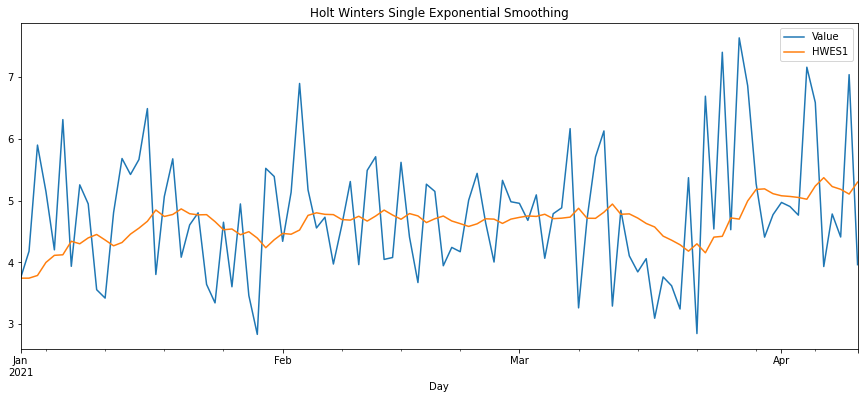

In [26]:
# holt winters (somente com o nível)
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Set the value of Alpha and define m (Time Period)
alpha = 0.1
df['HWES1'] = SimpleExpSmoothing(df['Value']).fit(smoothing_level=alpha,
                                                  optimized=False,
                                                  use_brute=True).fittedvalues
df[['Value','HWES1']].plot(title='Holt Winters Single Exponential Smoothing');

Em seguida, é o modelo de Holt-Winters somente com a tendência, para um modelo aditivo e multiplicativo:

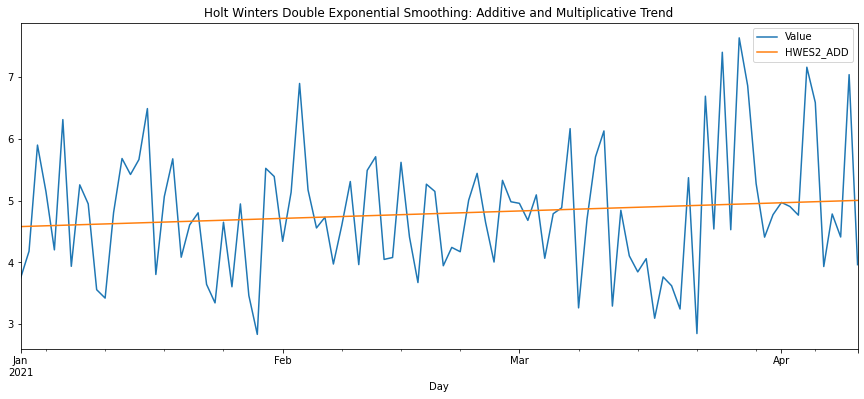

In [31]:
# holt winters (somente com o nível e a tendência aditiva e multiplicativa)
df['HWES2_ADD'] = ExponentialSmoothing(df['Value'],trend='add').fit().fittedvalues
df['HWES2_MUL'] = ExponentialSmoothing(df['Value'],trend='mul').fit().fittedvalues
df[['Value','HWES2_ADD']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend');

Gráfico: Holt-Winters somente com a tendência para um modelo aditivo e multiplicativo.

Por último, temos o modelo de Holt-Winters com nível, com a tendência e sazonalidade, tanto para um modelo aditivo quanto multiplicativo:

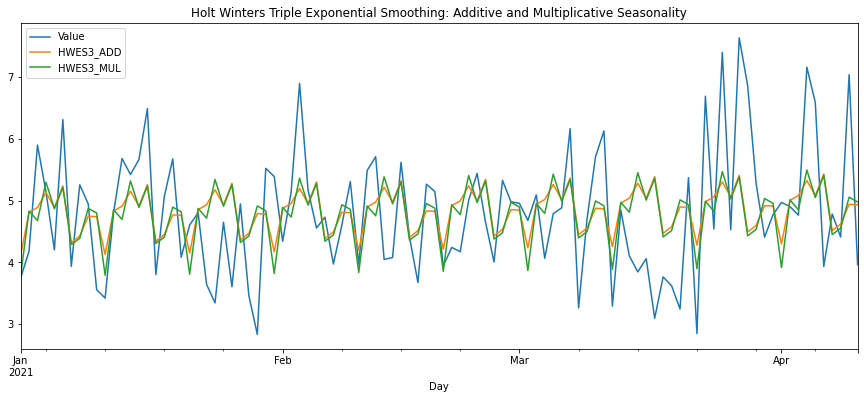

In [32]:
# holt winters (nível, tendência e sazonalidade, aditiva e multiplicativa)

df['HWES3_ADD'] = ExponentialSmoothing(df['Value'],trend='add',seasonal='add',seasonal_periods=10).fit().fittedvalues
df['HWES3_MUL'] = ExponentialSmoothing(df['Value'],trend='mul',seasonal='mul',seasonal_periods=10).fit().fittedvalues
df[['Value','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')


Gráfico: Holt-Winters com nível, tendência e sazonalidade para modelo aditivo e modelo multiplicativo.

Vamos fazer a previsão, utilizando o modelo de Holt-Winters. Começaremos dividindo o conjunto de dados em treino e teste. Pegamos 90 dados como conjunto de treino e os últimos 10 últimos pontos de dados como conjunto de teste:

Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

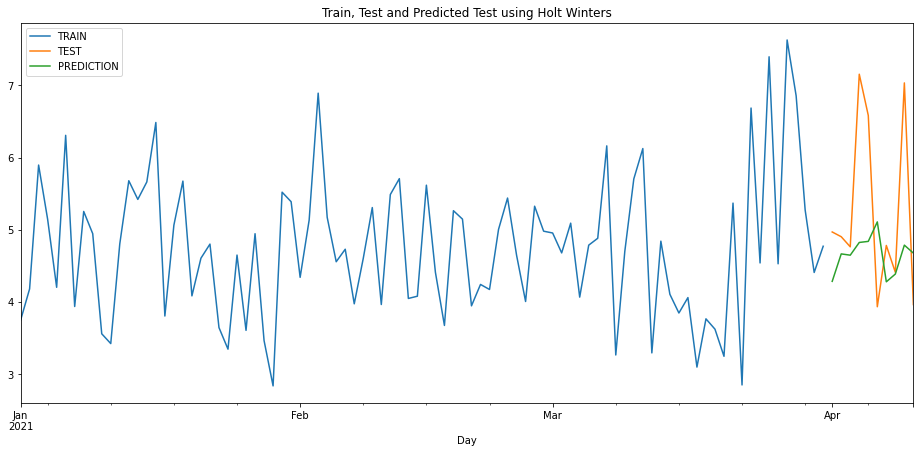

In [33]:
#Previsão 10 passos a frente com modelo de Holt-Winters
train_df = df[:90]
test_df = df[90:]
fitted_model = ExponentialSmoothing(train_df['Value'],trend='mul', 
                                    seasonal='mul',
                                    seasonal_periods=10).fit()
test_predictions = fitted_model.forecast(10)
train_df['Value'].plot(legend=True,label='TRAIN')
test_df['Value'].plot(legend=True,label='TEST',figsize=(16,7))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

Gráfico: Previsão 10 passos à frente com modelo de Holt-Winters.

Podemos observar que as previsões feitas com o modelo de Holt-Winters se ajustam bem, pois, comparando o período de teste com os valores previstos, vemos que existe o mesmo comportamento da série.

### Modelagem ARIMA 

Utilizaremos a metodologia proposta por Box & Jenkins para a análise de uma série temporal logística, começando pela identificação do modelo. A identificação não pretende definir o modelo final para representar a série. Se assim fosse, não haveria necessidade das outras etapas de modelagem. Como já vimos, o objetivo é apenas definir os valores de p, d e q que, inicialmente, sejam adequados para modelar a série porque, segundo os autores do método, esse diagnóstico costuma conduzir a um modelo subespecificado, menor do que o modelo verdadeiro para a série.

Fazemos o gráfico da função de autocorrelação (FAC) e função de autocorrelação parcial (FAC) para confirmar se a série é estacionária.

In [34]:
# exibir os principais dados
df.head()

,Value,HWES1,HWES2_ADD,HWES2_MUL,HWES3_ADD,HWES3_MUL
Day,,,,,,
2021-01-01,3.745412,3.745412,4.579421,4.576713,4.107433,3.776239
2021-01-02,4.180482,3.745412,4.583698,4.580915,4.811023,4.831607
2021-01-03,5.897133,3.788919,4.587976,4.585122,4.888370,4.676017
2021-01-04,5.146392,3.999740,4.592253,4.589332,5.131453,5.297298
2021-01-05,4.203034,4.114405,4.596531,4.593545,4.888486,4.867372


In [35]:
df_novo = df.drop(columns=['HWES1', 'HWES2_ADD','HWES2_MUL','HWES3_ADD','HWES3_MUL'])
df_novo.head()

,Value
Day,
2021-01-01,3.745412
2021-01-02,4.180482
2021-01-03,5.897133
2021-01-04,5.146392
2021-01-05,4.203034


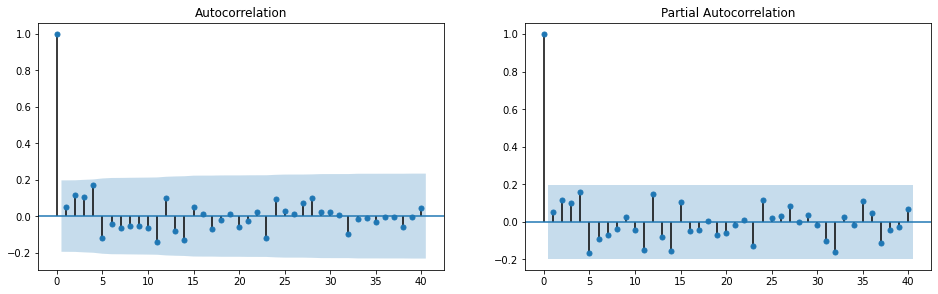

In [36]:
# Função de autocorrelação (FAC) e função de autocorrelação parcial (FAC)

def acf_pacf(x):
  
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=40, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=40, ax=ax2)

acf_pacf(df_novo)

Observa-se que a FAC decai exponencialmente como senoides amortecidas e a FACP possui o lag 1 significativo, ou seja, truncada no lag 1, o que sugere um modelo de médias móveis de ordem 1.

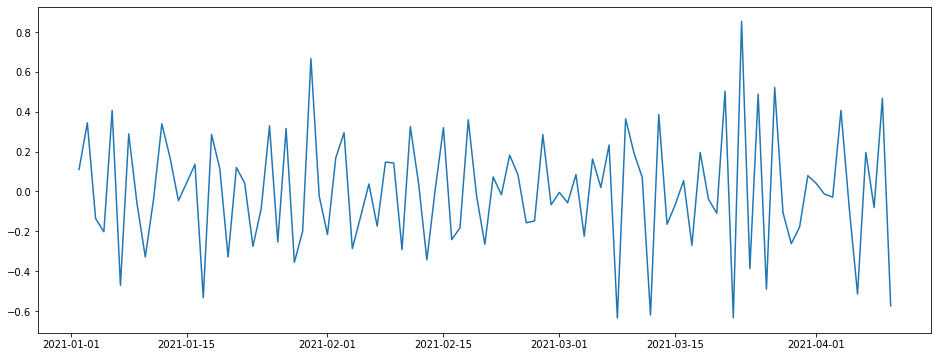

In [37]:
#Transformação para tornar a série estacionária
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
ax.plot(np.log(df_novo).diff().dropna());

Gráfico: Série estacionária.

Dessa maneira, o procedimento sugerido por Box & Jenkins para a identificação das ordens p e q de um modelo de séries temporais é, a partir da série que se quer analisar, estimar a FAC obtendo o gráfico da FAC e da FACP amostral.

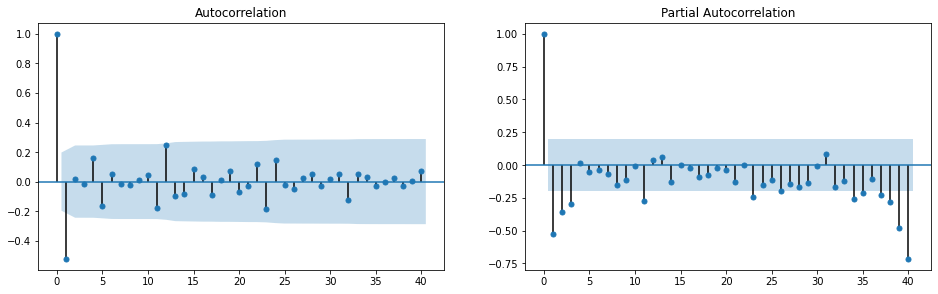

In [38]:
# FAC e FACP para série estacionária
acf_pacf(np.log(df_novo).diff().dropna())

Gráfico: FAC e FACP para série não estacionária.

A série transformada, após uma diferença, ou seja, foi identificado que d=1 e aplicada à função logarítmica ficou não estacionária. E como a condição para estimar o modelo ARIMA é que a série não seja estacionária, podemos seguir com a análise:

Observamos que, mesmo após a diferença, a série apresenta os pontos fora do intervalo de confiança; esses pontos estão ocorrendo a cada lag múltiplo de 10, o que caracteriza que necessita de diferença sazonais.

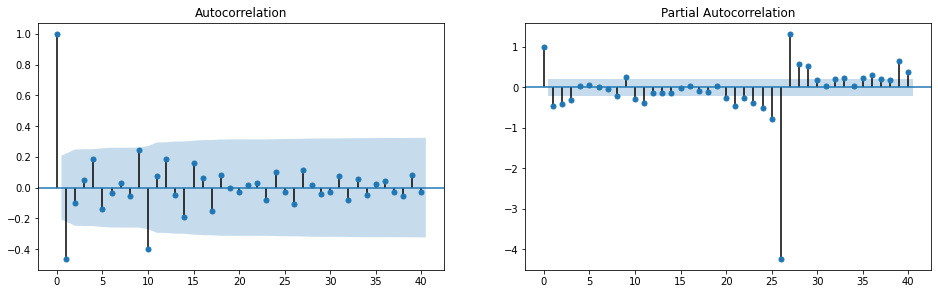

In [39]:
# FAC e FACP para série estacionária
acf_pacf(np.log(df_novo).diff().diff(10).dropna())

Gráfico: FAC e FACP para série não estacionária.

A FAC está truncada em q=1, o que poderia sugerir um modelo MA(2) e a FACP apresenta uma mistura dos comportamentos. Para a séria da PIM, o modelo sugerido seria um SARIMA(p,d,q)(P,D,Q), por se tratar de um modelo sazonal, mas estimaremos um modelo ARIMA(p,d,q) para ilustração.

Faremos mais uma transformação, elevando ao quadrado o valor da variação da PIM:

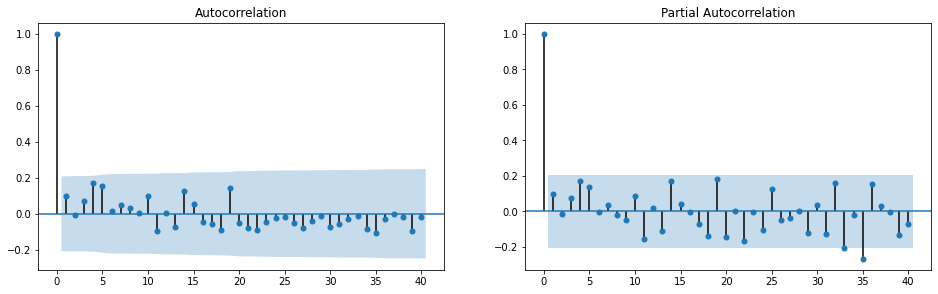

In [40]:
acf_pacf(np.log(df_novo).diff().diff(10).dropna() ** 2)

Gráfico: Modelo ARIMA(p,d,q).

O valor da série da PIM transformada apresenta tanto características de AR(1) como de MA(1), caracterizando um processo ARMA(1,1), pois a FAC de um MA(1) é truncada em q=1 e a FACP de um AR(1) é truncada em p=1. Essa é a fase de identificação.

Na fase de estimação, estimamos os parâmetros do modelo, sendo assim, estimaremos o modelo ARIMA(p,d,q), em que p=1, q=1 e d=1, sendo um ARIMA(1,1,1):

In [41]:
# Ajuste do modelo ARIMA(1,1,1)
model = sm.tsa.ARIMA(1000 * (np.log(df_novo).diff().dropna() ** 2), 
                     order=(1,1,1)).fit()
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                   98
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -605.926
Method:                       css-mle   S.D. of innovations            114.832
Date:                Thu, 27 Jan 2022   AIC                           1219.852
Time:                        00:36:36   BIC                           1230.192
Sample:                    01-03-2021   HQIC                          1224.034
                         - 04-10-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8383      0.553      1.516      0.133      -0.246       1.922
ar.L1.D.Value     0.2773      0.099      2.790      0.006       0.082       0.472
ma.L1.D.Value    -0.9999      0.034    -

Ajuste do modelo ARIMA(1,1,1)

Porém, como mencionado antes, esse não necessariamente é o modelo final, uma vez que o procedimento de identificação tende a subidentificar o modelo, isto é, a conduzir a valores de p e/ou q que são menores que os reais. Uma vez identificado e estimado um modelo, devemos diagnosticar o modelo e verificar se os resíduos apresentam as propriedades esperadas para eles. Ou seja, se eles se comportam como um ruído branco.

**O passo mais importante é detectar a possibilidade de autocorrelação. Se os resíduos apresentarem algum padrão de dependência temporal, o modelo é invalidado.**

Para começar a fase de diagnóstico, vamos fazer o gráfico dos resíduos:

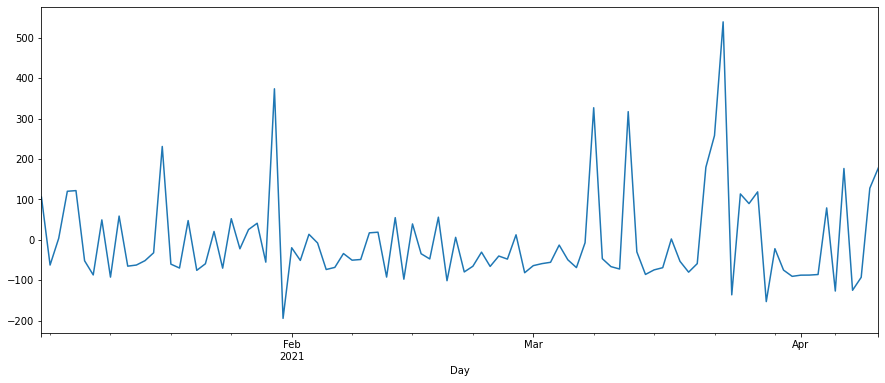

In [42]:
# Gráfico dos resíduos
model.resid.plot()

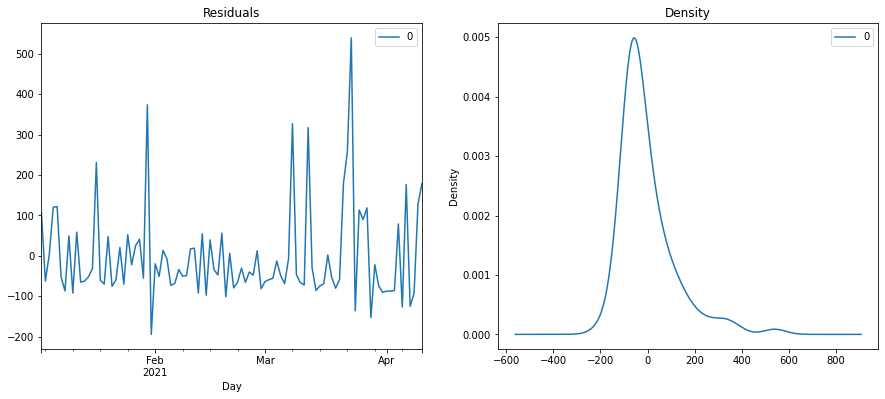

In [43]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Gráfico: Resíduos.

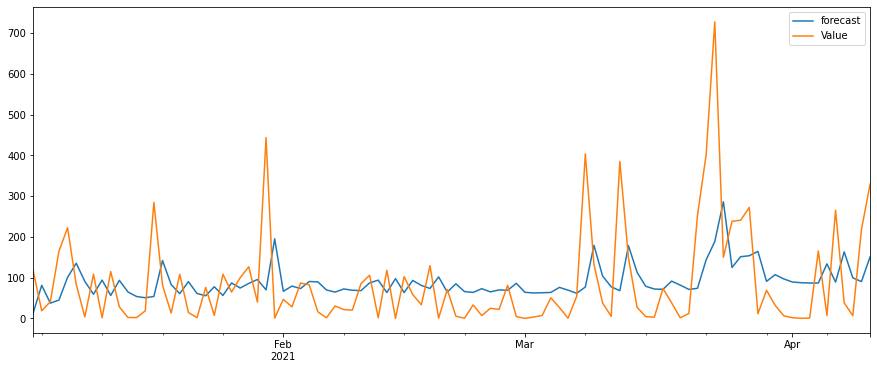

In [44]:
# Vamos verificar a previsão e também a precisão do modelo
model.plot_predict(dynamic=False)
plt.show()

Gráfico: Previsão - Real x Estimado.

Os resultados são satisfatórios, mas é bom ter uma ideia de como o ARIMA funciona. Vamos fazer uma verificação rápida da métrica de precisão no mesmo para ver o quão bem o modelo pode prever o valor futuro.

In [45]:
train_df = df[:90]
test_df = df[90:]

In [46]:
train_df.head()

,Value,HWES1,HWES2_ADD,HWES2_MUL,HWES3_ADD,HWES3_MUL
Day,,,,,,
2021-01-01,3.745412,3.745412,4.579421,4.576713,4.107433,3.776239
2021-01-02,4.180482,3.745412,4.583698,4.580915,4.811023,4.831607
2021-01-03,5.897133,3.788919,4.587976,4.585122,4.888370,4.676017
2021-01-04,5.146392,3.999740,4.592253,4.589332,5.131453,5.297298
2021-01-05,4.203034,4.114405,4.596531,4.593545,4.888486,4.867372


In [47]:
test_df.head()

,Value,HWES1,HWES2_ADD,HWES2_MUL,HWES3_ADD,HWES3_MUL
Day,,,,,,
2021-04-01,4.969813,5.077321,4.964387,4.970795,4.300048,3.916679
2021-04-02,4.903908,5.066570,4.968665,4.975360,5.003640,5.011882
2021-04-03,4.764228,5.050304,4.972942,4.979928,5.080984,4.850718
2021-04-04,7.156139,5.021696,4.977219,4.984500,5.324068,5.494564
2021-04-05,6.584497,5.235140,4.981497,4.989077,5.081101,5.049332


In [48]:
train_df2 = train_df.drop(columns=['HWES1', 'HWES2_ADD','HWES2_MUL','HWES3_ADD','HWES3_MUL'])
train_df2.head()

,Value
Day,
2021-01-01,3.745412
2021-01-02,4.180482
2021-01-03,5.897133
2021-01-04,5.146392
2021-01-05,4.203034


In [49]:
test_df2 = test_df.drop(columns=['HWES1', 'HWES2_ADD','HWES2_MUL','HWES3_ADD','HWES3_MUL'])
test_df2.head()

,Value
Day,
2021-04-01,4.969813
2021-04-02,4.903908
2021-04-03,4.764228
2021-04-04,7.156139
2021-04-05,6.584497


In [50]:
import numpy as np

model2 = sm.tsa.ARIMA(train_df2, order=(1, 1, 1))  
fitted = model2.fit(disp=-1)

# Forecast
fc, se, conf = fitted.forecast(1, alpha=0.05)

# MAPE - Mean Absolute Percentage Error
mape = np.mean(np.abs(fc - test_df2)/np.abs(test_df2))

In [ ]:
mape

Value    0.138264
dtype: float64

O MAPE é de 0.1382, ou seja, a precisão do modelo é de 99,86%.

O Mean Absolute Percentage Error (MAPE) - erro percentual médio absoluto é um dos KPIs mais usados para medir a precisão da previsão.